In [1]:
import numpy as np
import json

from custom_losses import *
from data import *
from models.random_features import *
from models.mean_variance import *
from training_functions import *

for both types of models RandomFeatures and MeanVarianceModel, we load the optimal regularization and train 10 models with different seeds. For the RandomFeatures we train them using the AggregateGaussianNLLLoss and for the MeanVarianceModel we train them independently using the GaussianNLLLoss. We then average the predictions of the 10 models to get the final prediction and get the prediction variance.

In [2]:
n_models = 20
np.random.seed(0)
seeds = [np.random.randint(0, 100000) for _ in range(n_models)]

In [27]:
n = 1000
d = 100
hidden_width_list = [25, 50, 100, 200, 250, 500, 750, 1000, 1250, 1500]
freeze_first_layer= False

In [28]:
# define the data
n_val = 100
teacher, x_train, y_train = generate_teacher_and_data(n, d, 1.0, seed = 0)
data_loader = create_data_loader(x_train, y_train, batch_size = 32, shuffle=True)
x_val, y_val = get_data_from_teacher(teacher, n_val, d, 1.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:43<00:00, 22.78it/s]


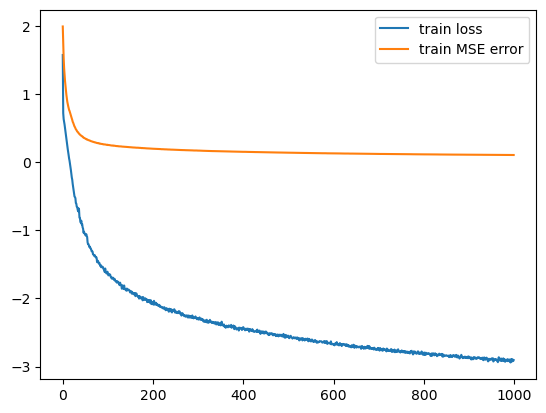

 86%|████████▋ | 863/1000 [00:41<00:08, 17.09it/s]

In [30]:
learning_rate = 1e-1
n_epochs = 1000

randomfeatures_mses_val = []
randomfeatures_prediction_variances_val = []

for hidden_width in hidden_width_list:
    # load the optimal weight decay
    ## filename = f"optimal_weight_decay_results/RandomFeatures_freeze_first_layer=({freeze_first_layer})_n=({n})_d=({d})_hidden_width={hidden_width}.json"
    ## with open(filename, "r") as f:
    ##     optimal_weight_decay = json.load(f)["optimal_weight_decay"]

    optimal_weight_decay = 0.0 # small weight decay for now, we'll probably overfit

    # build the model 
    models = [RandomFeatures(input_dim=d, hidden_width=hidden_width, activation=torch.tanh, seed=seed, freeze_first_layer=freeze_first_layer) for seed in seeds]

    # display the gram matrix between the models 1st layers

    if freeze_first_layer:
        gram_matrix = np.zeros((n_models, n_models))
        for i in range(n_models):
            for j in range(n_models):
                # fill with the trace of the product of the two 1st layers
                gram_matrix[i, j] = np.trace(models[i].first_layer.weight @ models[j].first_layer.weight.T) / hidden_width**2
    ## plt.imshow(gram_matrix)
    ## plt.colorbar()
    ## plt.title(f"hidden_width={hidden_width}")
    ## plt.show()

    # filter the params by requires_grad directly in the optimizer
    params = []
    for module in models:
        params += [p for p in module.parameters() if p.requires_grad]

    optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=optimal_weight_decay)
    data_loader = create_data_loader(x_train, y_train, batch_size = 100, shuffle=True)

    result_0 = training_loop_several_models_aggregate_loss(models, data_loader, AggregateGaussianNLL(), optimizer, n_epochs=n_epochs, x_val=None, y_val=None)

    # plot the training error and training loss accross traiing
    plt.plot(result_0["loss"], label="train loss")
    plt.plot(result_0["error"], label="train MSE error")
    plt.legend()
    plt.show()

    # evalute on validation set 
    predictions = torch.cat([model(x_val) for model in models], dim=1)

    mean = predictions.mean(dim=1)
    mse_val = ((mean - y_val)**2).mean().item()
    prediction_variance_val = torch.var(predictions, dim=1).mean().item()

    randomfeatures_mses_val.append(mse_val)
    randomfeatures_prediction_variances_val.append(prediction_variance_val)

    # plt.plot(result_0["loss_val"], label="val loss")
    # plt.plot(result_0["error_val"], label="val MSE error")
    # plt.plot(result_0["prediction_variance_val"], label="val p.v.")
    # plt.legend()
    # plt.title(f"hidden_width={hidden_width}")
    # plt.show()

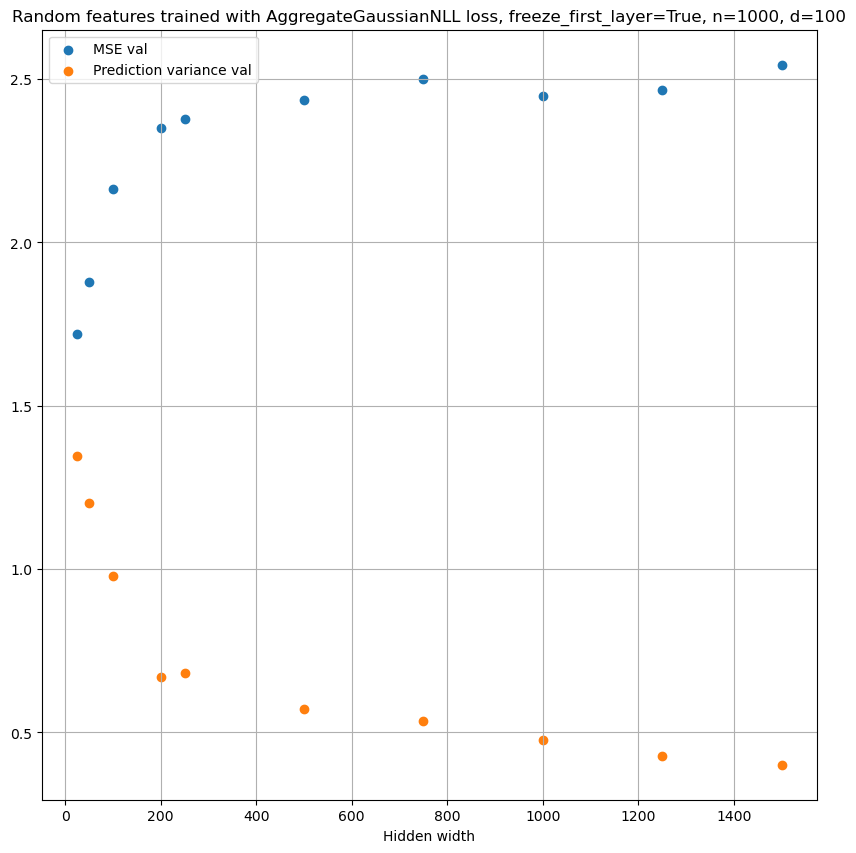

In [26]:
plt.figure(figsize=(10, 10))

plt.scatter(hidden_width_list, randomfeatures_mses_val, label="MSE val")
plt.scatter(hidden_width_list, randomfeatures_prediction_variances_val, label="Prediction variance val")
plt.xlabel("Hidden width")

plt.grid()
plt.title(f"Random features trained with AggregateGaussianNLL loss, freeze_first_layer={freeze_first_layer}, n={n}, d={d}")
plt.legend()

100%|██████████| 2000/2000 [00:39<00:00, 51.11it/s]


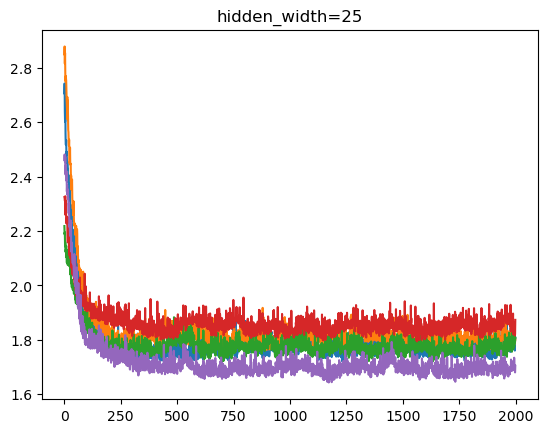

100%|██████████| 2000/2000 [00:38<00:00, 52.12it/s]


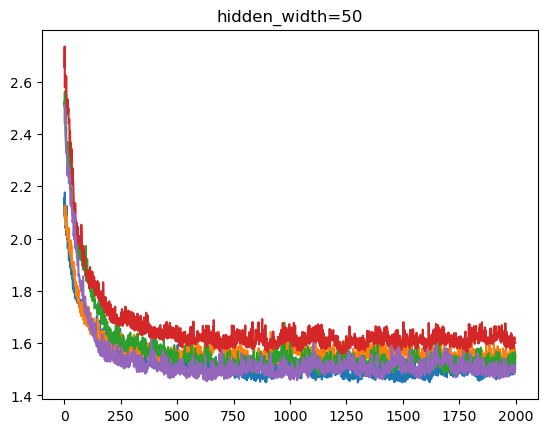

100%|██████████| 2000/2000 [00:39<00:00, 50.24it/s]


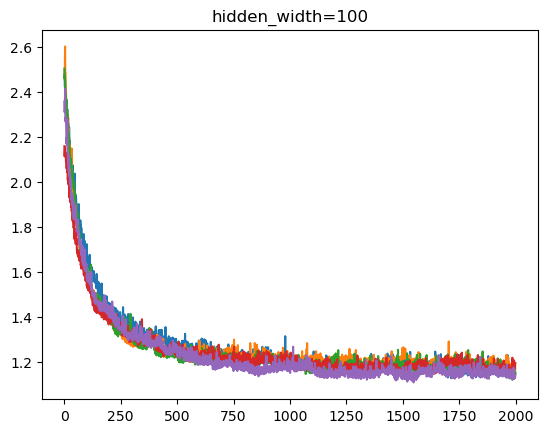

100%|██████████| 2000/2000 [00:41<00:00, 47.78it/s]


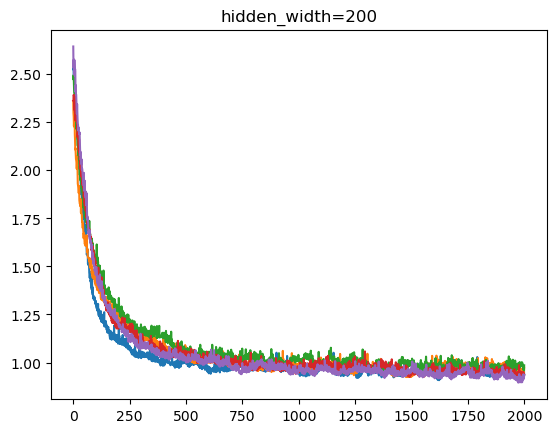

100%|██████████| 2000/2000 [00:38<00:00, 52.29it/s]


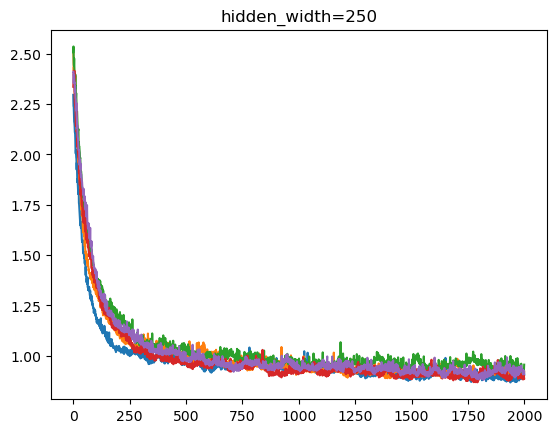

100%|██████████| 2000/2000 [00:45<00:00, 43.89it/s]


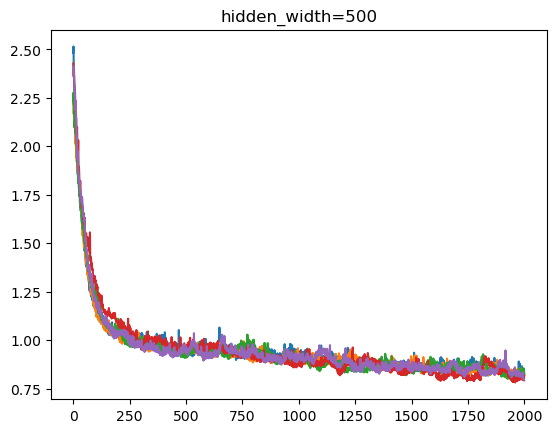

100%|██████████| 2000/2000 [00:47<00:00, 41.69it/s]


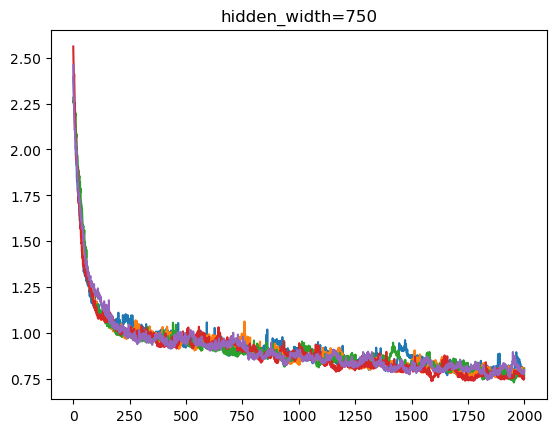

100%|██████████| 2000/2000 [00:55<00:00, 36.21it/s]


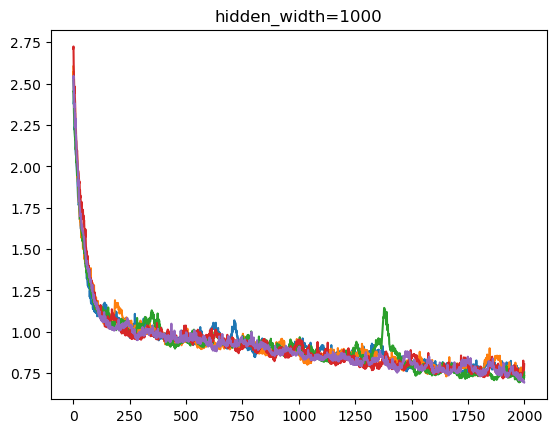

100%|██████████| 2000/2000 [00:49<00:00, 40.08it/s]


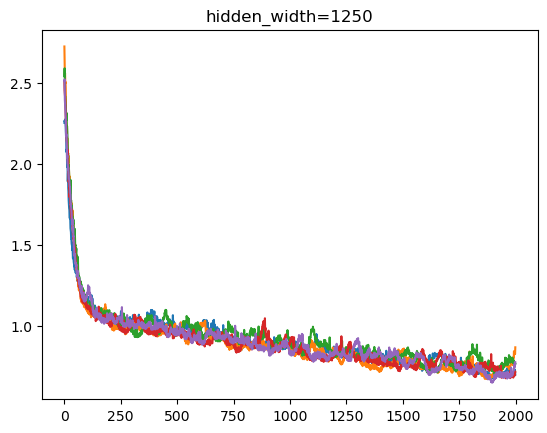

100%|██████████| 2000/2000 [00:51<00:00, 38.65it/s]


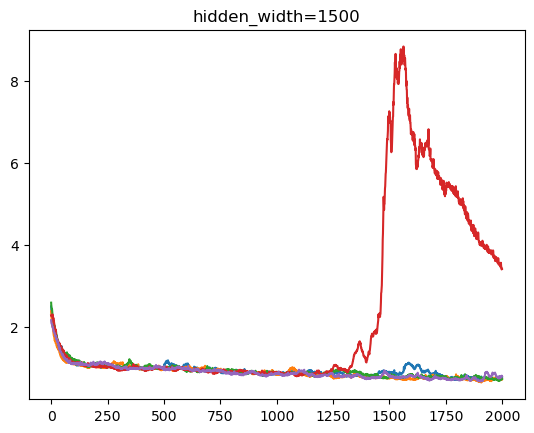

In [21]:
# NOW WE DO THE SAME WITH "DEEP" ENSEMBLES = MEAN VARIANCE ESTIMATORS

learning_rate = 5e-2
n_epochs = 2000

mses_val = []
prediction_variances_val = []

for hidden_width in hidden_width_list:
    results = []
    # load the optimal weight decay
    ## filename = f"optimal_weight_decay_results/MeanVarianceModel_freeze_first_layer=({freeze_first_layer})_n=({n})_d=({d})_hidden_width={hidden_width}.json"
    ## with open(filename, "r") as f:
    ##     optimal_weight_decay = json.load(f)["optimal_weight_decay"]

    optimal_weight_decay = 0.0
        
    models = [MeanVarianceModel(input_dim=d, hidden_width=hidden_width, activation=torch.tanh, seed=seed, freeze_first_layer=freeze_first_layer) for seed in seeds[:5]]
    optimizers = [torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=learning_rate) for model in models]

    errors = []

    # train the models independently
    data_loader = create_data_loader(x_train, y_train, batch_size = 32, shuffle=True)
    for model, optimizer in zip(models, optimizers):
        result = training_loop_single_model(model, data_loader, GaussianNLLForMeanVariance(), MSEForMeanVariance(), optimizer, n_epochs=n_epochs)
        results.append(result)
        errors.append(result["error"])

    for error in errors:
        plt.plot(error)
    plt.title(f"hidden_width={hidden_width}")
    plt.show()

    # on the validation data, compare the MSE and the prediction variance (variance of outpurs w.r.t the models) 
    predictions = [model(x_val) for model in models]
    means_ = torch.cat([pred[0] for pred in predictions], dim=1)
    variances_ = torch.cat([pred[1] for pred in predictions], dim=1)
    
    mean = means_.mean(dim=1)
    mse_val = ((mean - y_val)**2).mean().item()

    final_variances = variances_.mean(dim=1) + means_.var(dim=1)
    prediction_variance_val = final_variances.mean().item()
    x, y = ((mean - y_val[:, 0]).pow(2)).detach().numpy(), final_variances.detach().numpy()
    mses_val.append(mse_val)
    prediction_variances_val.append(prediction_variance_val)

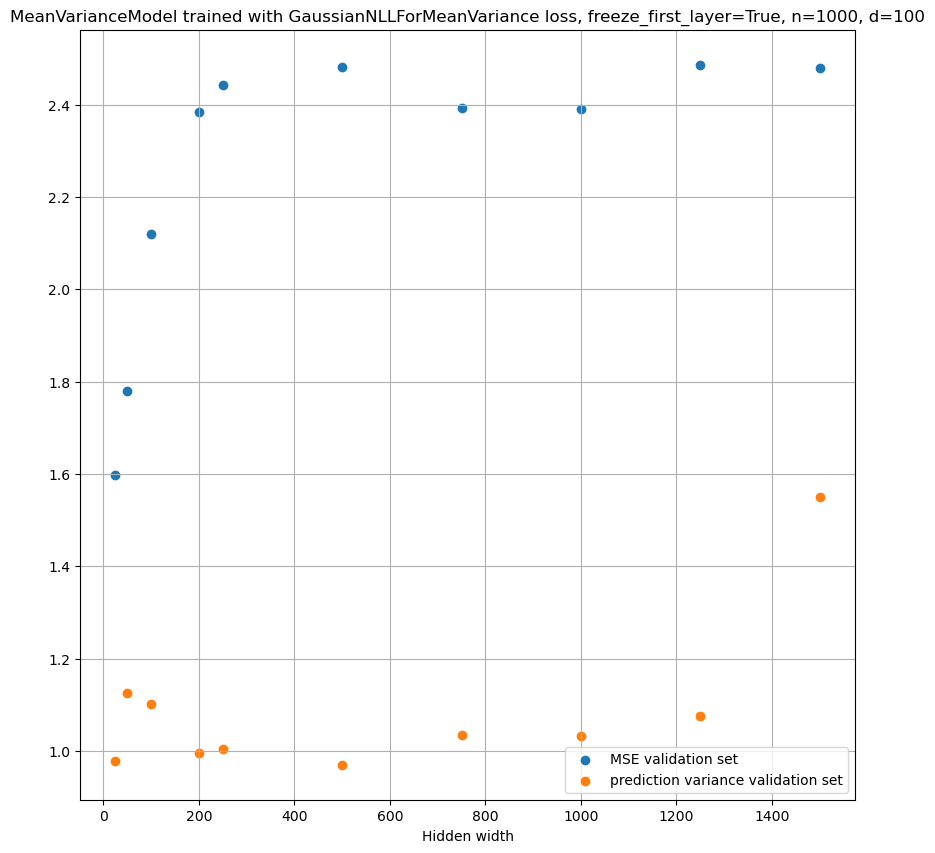

In [25]:
# square plot 
plt.figure(figsize=(10, 10))

plt.scatter(hidden_width_list, mses_val, label="MSE validation set")
plt.scatter(hidden_width_list, prediction_variances_val, label="prediction variance validation set")
plt.grid()
plt.xlabel("Hidden width")
plt.title(f"MeanVarianceModel trained with GaussianNLLForMeanVariance loss, freeze_first_layer={freeze_first_layer}, n={n}, d={d}")

plt.legend()
plt.show()